In [55]:
# importing Qiskit and necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import warnings
from qiskit.circuit.library import RealAmplitudes
warnings.filterwarnings('ignore')
from qiskit import *
from qiskit import Aer, execute

In [56]:
# Importing Runtime sampler using Sessions
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

In [57]:
# Save the Runtime account credenials if you have not done so already
# If you need to overwrite the account info, please add `overwrite=True`
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True)

In [58]:
# authenticate at Qiskit runtime service
service = QiskitRuntimeService()
# choose a cloud simulator
backend = service.backends(simulator=True)[0]

In [59]:
#Next we will be using the noisy simulator,
#for that we need to create a noise model with a fake backend from the fake provider.

#The fake provider module contains fake providers and fake backends classes.
#The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots.
#The system snapshots contain important information about the quantum system such as coupling map, basis gates,
#qubit properties (T1, T2, error rate, etc.) which are useful for performing noisy simulation of the system.

#In this case, we will import `FakeManila` to make the noise model. With the model,
#we can configure several data which are noise model, basis gates, coupling map, and seed in `simulator` option inside of `Options`.

In [60]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel


# Do not change the seed of simulatior in Options

options = Options(simulator={"seed_simulator": 1234},resilience_level=0)
shots = 10000

fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)



options_noise = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 1234
    },
    resilience_level=0
)
options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 1234
    },
    resilience_level=1,
)

In [61]:
#setting up auxiliary functions for data processing and plotting of results here.
def process_samples(circuit, samples):
    """maps dictionary of (quasi-) probabilities to dense vector for illustration.
       (scales exponentially! don't apply to too many qubits!."""
    probs = np.zeros(2**circuit.num_qubits)
    for b, p in samples.quasi_dists[0].items():
        probs[b] = p
    return probs

def plot_probabilities(circuit, probs, label):
    """plots probability vector."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    ax.bar(x, probs, align='center', alpha=1, label=label)
    ax.set_title('Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cumulative_probabilities(circuit, probs_list, labels):
    """plots multiple cumulative probabilities."""
    x = np.array(range(2**circuit.num_qubits))
    fig, ax = plt.subplots()
    for i, probs in enumerate(probs_list):
        ax.plot(x, np.cumsum(probs), label=labels[i], linewidth=2)
    ax.set_title('Cumulative Probabilities')
    ax.yaxis.grid(True)
    ax.xaxis.set_major_formatter(lambda x, pos: f'{int(x):0{circuit.num_qubits}b}')
    plt.xticks(x[::4], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_fidelities(fidelities_list, labels):
    """plots list of fidelities."""
    fig, ax = plt.subplots()
    for fidelity, label in zip(fidelities_list, labels):
        ax.plot(np.linspace(0, 1, len(fidelity)), fidelity, alpha=1, label=label, linewidth=2)
    ax.set_title('Fidelities')
    ax.yaxis.grid(True)
    plt.legend()
    plt.xlabel('c')
    plt.ylabel('fidelity')
    plt.tight_layout()
    plt.show()

def plot_matrix(A, title):
    """plots a given matrix."""
    # plot matrix
    plt.title(title)
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()

In [62]:
# import Scikit-learn, a machine learning library for Python
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [66]:
# load two class data (0 and 1) from sklearn dataset
digits = datasets.load_digits(n_class=2) 

# split dataset
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.7, random_state=22)

# reduce dimensions
n_dim = 8
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# standardize
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Normalize
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# select 25 set of data for learning and 10 for test 
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [67]:
# show the first data sample
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[-0.91749803 -0.16718998 -0.50461104 -0.39108743 -0.39591321 -0.20579425
  0.03043893  0.2636446 ] 0
[ 0.40600558 -0.74742494  0.73281596 -0.23290429 -0.35820492 -0.36234378
  0.14955469  0.00752033] 1


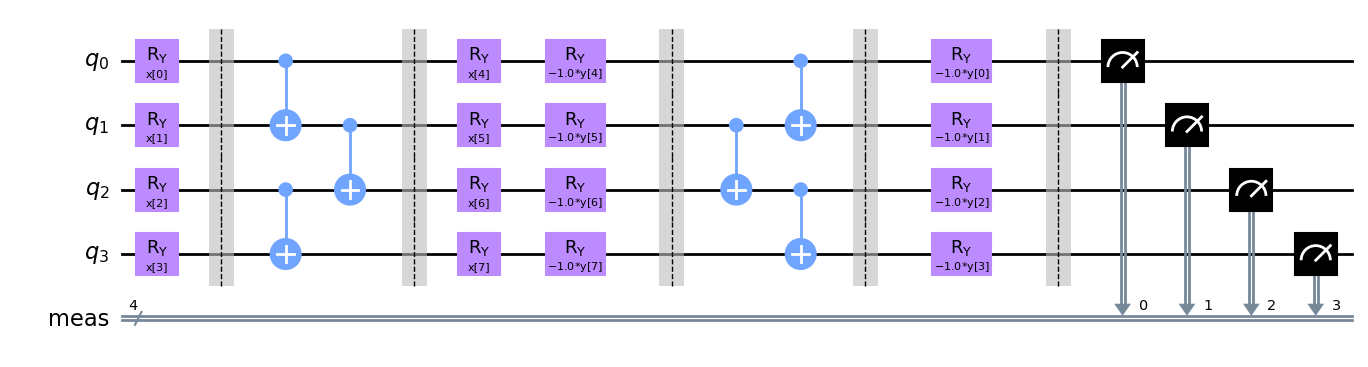

In [51]:
# parametrized circuit defining U first state
circuit_1 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='x')
    
# parametrized circuit V defining second state
circuit_2 = RealAmplitudes(4, reps=1, entanglement='pairwise', 
                           insert_barriers=True, parameter_prefix='y')

# combining circuits to evaluate U^dagger V
fidelity_circuit = circuit_1.copy()
fidelity_circuit.append(circuit_2.inverse().decompose(), range(fidelity_circuit.num_qubits))
fidelity_circuit.measure_all()

# drawing resulting circuit to estimate fidelity
fidelity_circuit.decompose().draw('mpl')

In [65]:
# We illustrate the fidelity estimation by parameters  𝜃1,𝜃2  for the two states.
# Then we calculate the fidelity between the state corresponding to  𝜃1  and the states corresponding to  𝜃1+𝑐∗(𝜃2−𝜃1)  for  𝑐∈[0,1] .

# Since we use the same parametrized circuit for both states,  𝑐=0  implies that both states correspond to  𝜃1  and the fidelity is supposed to be equal to  1 . With increasing  𝑐 , the fidelity declines (up to a certain point, depending on  𝜃2 ).

# We will input sample_train[0] and sample_train[2] for  𝜃1,𝜃2 .

In [52]:
# draw parameters for states 1 & 2
theta_1 = sample_train[0] # label"0"
theta_2 = sample_train[2] # label"1"

# linear combinations of theta_1 and theta_2
thetas = [theta_1 + c * (theta_2 - theta_1) for c in np.linspace(0, 1, 10)]

# list the parameters
theta_list = []
for theta_ in thetas:
    theta_list.append(list(theta_1) + list(theta_))

In [53]:
# create sampler using simulator and sample fidelities
    
    
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[fidelity_circuit] * len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_sim = job.result()

    sampler = Sampler(options=options_noise)
    job = sampler.run(circuits=[fidelity_circuit] * len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_noise = job.result()
    
    sampler = Sampler(options=options_with_em)
    job = sampler.run(circuits=[fidelity_circuit] * len(theta_list), parameter_values=theta_list, shots=shots)
    fidelity_samples_with_em = job.result()
    
fidelities_sim = []
fidelities_noise = []
fidelities_with_em = []

for i in range(10):
    fidelities_sim += [fidelity_samples_sim.quasi_dists[i][0]]
    fidelities_noise += [fidelity_samples_noise.quasi_dists[i][0]]
    fidelities_with_em += [fidelity_samples_with_em.quasi_dists[i][0]]

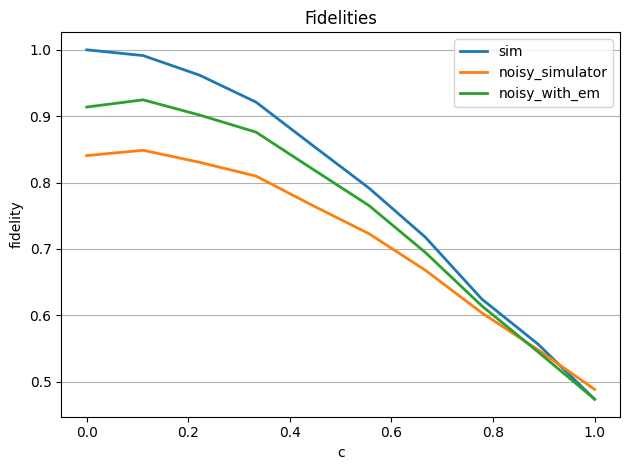

In [54]:
# plot resulting fidelities for different linear combinations of theta_1 and theta_2
plot_fidelities([fidelities_sim, fidelities_noise, fidelities_with_em], ['sim', 'noisy_simulator', 'noisy_with_em'])